In [1]:
!pip install yfinance pandas numpy matplotlib scipy

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


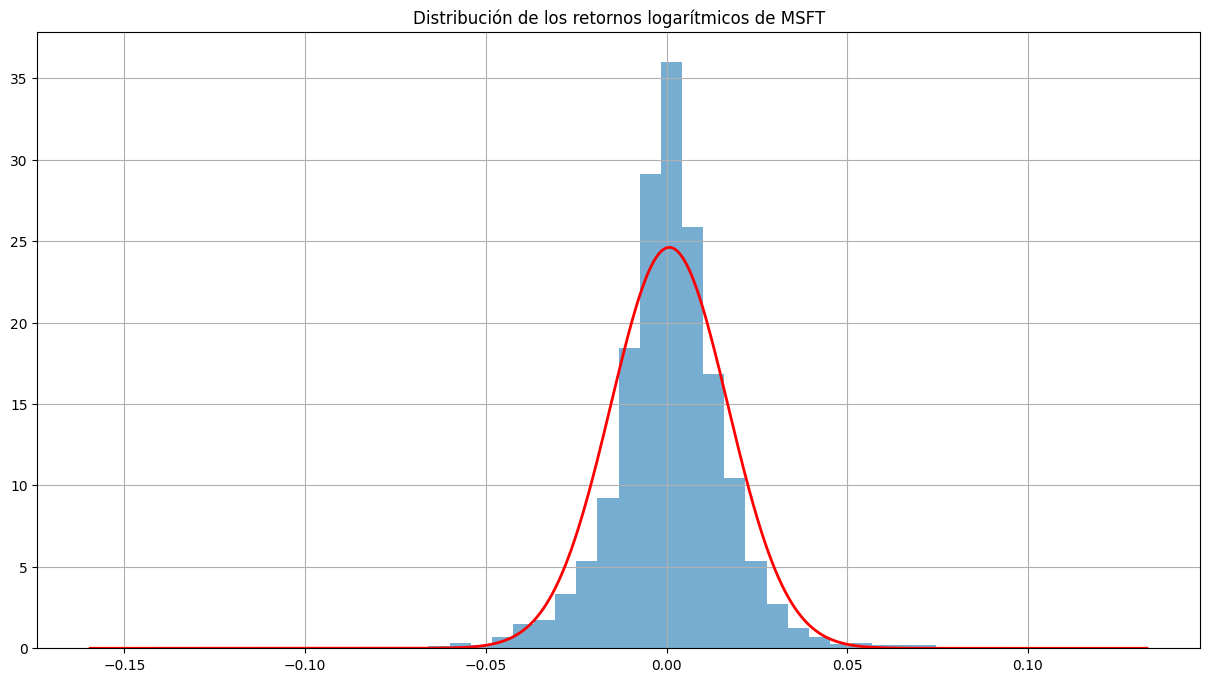

Probabilidad de caída >5% en un día: 8.65e-04
Probabilidad de caída >10% en un día: 2.51e-10
Probabilidad de caída >40% en 220 días: 8.79e-03
Probabilidad de caída >20% en 220 días: 6.15e-02
VaR al 5% (un día): -0.0259
Cuantil 25%: -0.0102
Cuantil 75%: 0.0117


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Descargar datos de Microsoft desde Yahoo Finance
ms = yf.download('MSFT', start='2010-01-01')

# Calcular el retorno logarítmico diario
ms['LogReturn'] = np.log(ms['Close'] / ms['Close'].shift(1))

# Parámetros de la distribución normal
mu = ms['LogReturn'].mean()
sigma = ms['LogReturn'].std(ddof=1)

# Histograma y ajuste normal
plt.figure(figsize=(15,8))
ms['LogReturn'].hist(bins=50, density=True, alpha=0.6)
x = np.linspace(ms['LogReturn'].min(), ms['LogReturn'].max(), 1000)
plt.plot(x, norm.pdf(x, mu, sigma), 'r', lw=2)
plt.title('Distribución de los retornos logarítmicos de MSFT')
plt.show()

# Probabilidad de caída mayor al 5% y 10% en un día
p_5 = norm.cdf(-0.05, mu, sigma)
p_10 = norm.cdf(-0.10, mu, sigma)
print(f'Probabilidad de caída >5% en un día: {p_5:.2e}')
print(f'Probabilidad de caída >10% en un día: {p_10:.2e}')

# Probabilidad de caída mayor al 40% y 20% en 220 días
mu220 = 220 * mu
sigma220 = np.sqrt(220) * sigma
p_40y = norm.cdf(-0.40, mu220, sigma220)
p_20y = norm.cdf(-0.20, mu220, sigma220)
print(f'Probabilidad de caída >40% en 220 días: {p_40y:.2e}')
print(f'Probabilidad de caída >20% en 220 días: {p_20y:.2e}')

# Value at Risk (VaR) y cuantiles
VaR_5 = norm.ppf(0.05, mu, sigma)
q25 = norm.ppf(0.25, mu, sigma)
q75 = norm.ppf(0.75, mu, sigma)
print(f'VaR al 5% (un día): {VaR_5:.4f}')
print(f'Cuantil 25%: {q25:.4f}')
print(f'Cuantil 75%: {q75:.4f}')

Volatilidad anualizada: 25.73%


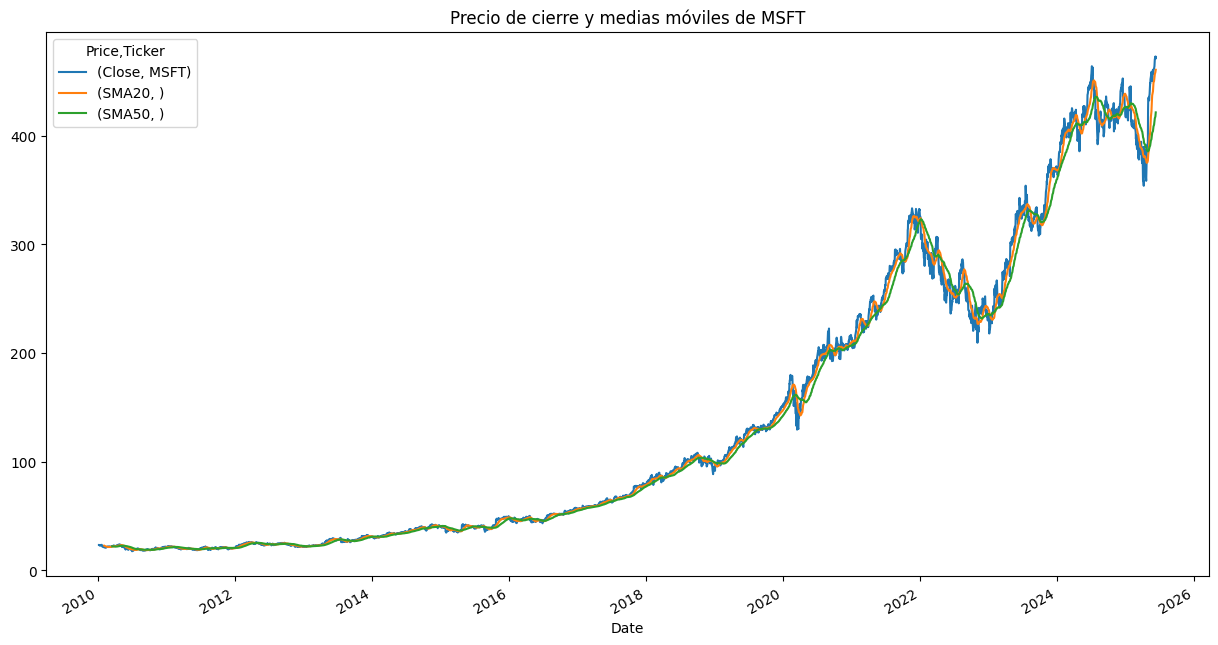

In [3]:
# Retorno acumulado
ms['Cumulative Return'] = (1 + ms['LogReturn']).cumprod()

# Volatilidad anualizada
vol_anual = ms['LogReturn'].std() * np.sqrt(252)
print(f'Volatilidad anualizada: {vol_anual:.2%}')

# Media móvil de 20 y 50 días
ms['SMA20'] = ms['Close'].rolling(window=20).mean()
ms['SMA50'] = ms['Close'].rolling(window=50).mean()

# Gráfico de precios y medias móviles
ms[['Close', 'SMA20', 'SMA50']].plot(figsize=(15,8))
plt.title('Precio de cierre y medias móviles de MSFT')
plt.show()

[*********************100%***********************]  8 of 8 completed


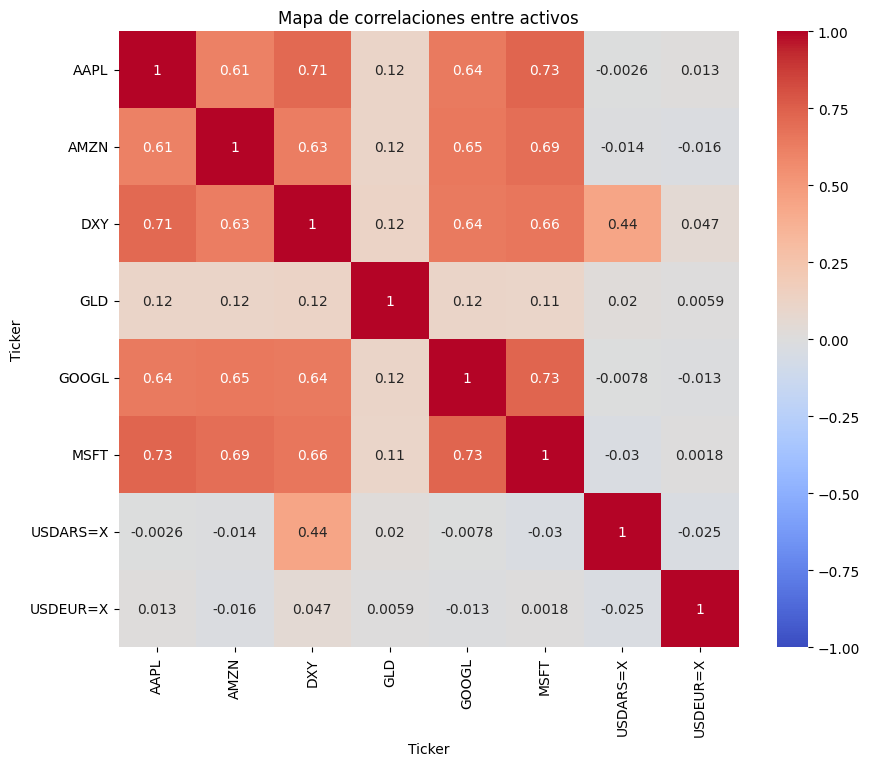

In [5]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Lista de tickers: puedes agregar o quitar los que quieras
tickers = [
    'MSFT',        # Microsoft
    'AAPL',        # Apple
    'GOOGL',       # Google
    'AMZN',        # Amazon
    'DXY',         # Dólar Index (puede ser ^DXY o DXY)
    'GLD',         # ETF de oro (o XAUUSD=X para oro spot)
    'USDEUR=X',    # Dólar/Euro
    'USDARS=X'     # Dólar/Argentino (cambiar por tu país si quieres)
]

# Descargar precios de cierre ajustados
data = yf.download(tickers, start='2020-01-01')['Close']

# Calcular retornos logarítmicos diarios
returns = np.log(data / data.shift(1))

# Calcular la matriz de correlación
corr_matrix = returns.corr()

# Graficar el heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Mapa de correlaciones entre activos')
plt.show()

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import norm

# Lista de activos
tickers = ['MSFT', 'AAPL', 'GOOGL', 'AMZN', 'GLD', 'DX-Y.NYB']

# Descargar precios de cierre ajustados
data = yf.download(tickers, start='2020-01-01')['Close']

# Calcular retornos logarítmicos diarios
returns = np.log(data / data.shift(1)).dropna()


#CALCULAMOS VAR Y EX PARA CADA ACTIVO


# Nivel de confianza (por ejemplo, 5% para VaR al 95%)
alpha = 0.05

# DataFrames para guardar resultados
VaR = pd.Series(index=returns.columns)
ES = pd.Series(index=returns.columns)

for col in returns.columns:
    mu = returns[col].mean()
    sigma = returns[col].std(ddof=1)
    # VaR paramétrico (asumiendo normalidad)
    VaR[col] = norm.ppf(alpha, mu, sigma)
    # ES paramétrico (asumiendo normalidad)
    ES[col] = mu - sigma * norm.pdf(norm.ppf(alpha)) / alpha

# Mostrar resultados
resultados = pd.DataFrame({'VaR (5%)': VaR, 'ES (5%)': ES})
print(resultados)




[*********************100%***********************]  6 of 6 completed

          VaR (5%)   ES (5%)
Ticker                      
AAPL     -0.033076 -0.041667
AMZN     -0.036952 -0.046489
DX-Y.NYB -0.007470 -0.009369
GLD      -0.015990 -0.020196
GOOGL    -0.033380 -0.042035
MSFT     -0.030803 -0.038836


In [8]:
VaR_hist = returns.quantile(alpha)
ES_hist = returns[returns.lt(VaR_hist)].mean()

resultados_hist = pd.DataFrame({'VaR histórico (5%)': VaR_hist, 'ES histórico (5%)': ES_hist})
print(resultados_hist)

          VaR histórico (5%)  ES histórico (5%)
Ticker                                         
AAPL               -0.032266          -0.047195
AMZN               -0.034316          -0.051991
DX-Y.NYB           -0.007309          -0.010408
GLD                -0.016224          -0.023177
GOOGL              -0.033042          -0.048677
MSFT               -0.028840          -0.043707


# ACLARACIONES
Se puede cambiar el nivel de confianza
Solo cambia el valor de alpha (por ejemplo, 0.01 para 99% de confianza).


# Interpretación
VaR (Value at Risk): Pérdida máxima esperada en un día (o periodo) con un nivel de confianza dado (por ejemplo, 5%).

ES (Expected Shortfall o CVaR): Promedio de las pérdidas que superan el VaR, es decir, el promedio de las peores pérdidas.

[*********************100%***********************]  6 of 6 completed


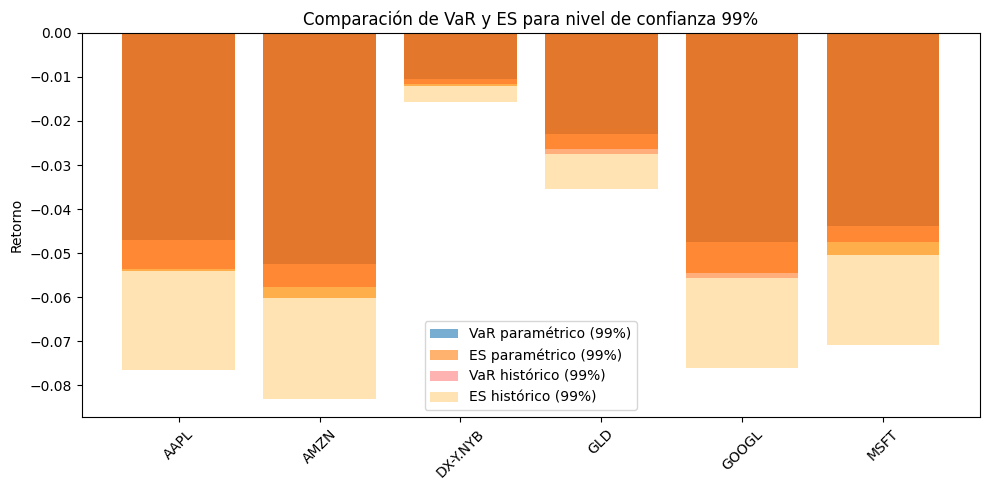

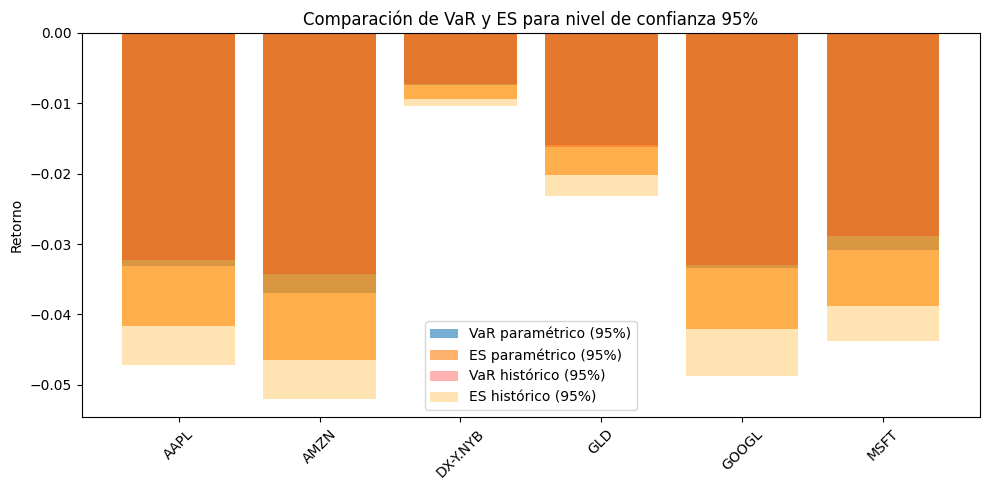

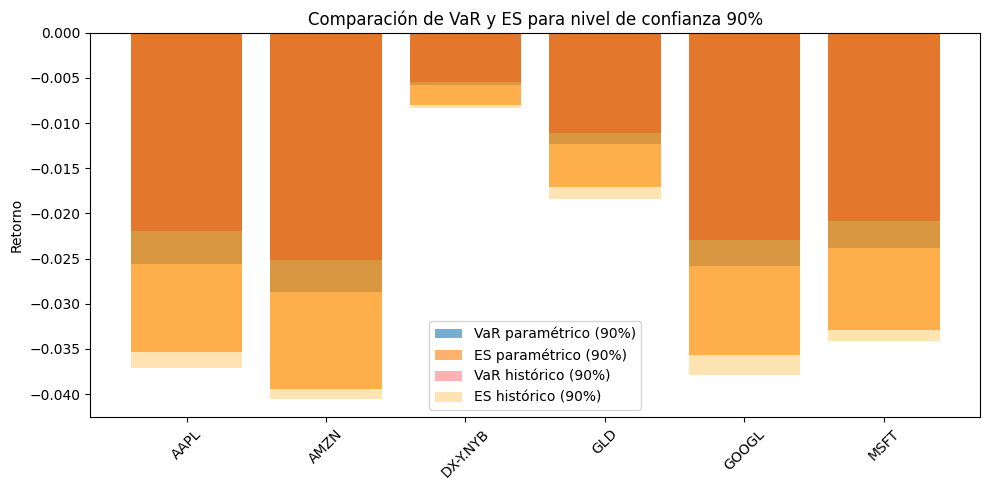

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Lista de activos
tickers = ['MSFT', 'AAPL', 'GOOGL', 'AMZN', 'GLD', 'DX-Y.NYB']

# Descargar precios
data = yf.download(tickers, start='2020-01-01')['Close']
returns = np.log(data / data.shift(1)).dropna()

# Niveles de confianza a analizar
conf_levels = [0.01, 0.05, 0.10]  # 99%, 95%, 90%

# DataFrames para guardar resultados
VaR_param = pd.DataFrame(index=returns.columns)
ES_param = pd.DataFrame(index=returns.columns)
VaR_hist = pd.DataFrame(index=returns.columns)
ES_hist = pd.DataFrame(index=returns.columns)

for alpha in conf_levels:
    # VaR y ES paramétricos (normalidad)
    VaR_param[alpha] = returns.apply(lambda x: norm.ppf(alpha, x.mean(), x.std(ddof=1)))
    ES_param[alpha] = returns.apply(lambda x: x.mean() - x.std(ddof=1) * norm.pdf(norm.ppf(alpha)) / alpha)
    # VaR y ES históricos (empíricos)
    VaR_hist[alpha] = returns.quantile(alpha)
    ES_hist[alpha] = returns.apply(lambda x: x[x < x.quantile(alpha)].mean())

# Transponer para graficar fácilmente
VaR_param = VaR_param.T
ES_param = ES_param.T
VaR_hist = VaR_hist.T
ES_hist = ES_hist.T

# Graficar comparación de VaR y ES para cada nivel de confianza
for alpha in conf_levels:
    plt.figure(figsize=(10,5))
    plt.bar(VaR_param.columns, VaR_param.loc[alpha], alpha=0.6, label=f'VaR paramétrico ({int((1-alpha)*100)}%)')
    plt.bar(ES_param.columns, ES_param.loc[alpha], alpha=0.6, label=f'ES paramétrico ({int((1-alpha)*100)}%)')
    plt.bar(VaR_hist.columns, VaR_hist.loc[alpha], alpha=0.3, label=f'VaR histórico ({int((1-alpha)*100)}%)', color='red')
    plt.bar(ES_hist.columns, ES_hist.loc[alpha], alpha=0.3, label=f'ES histórico ({int((1-alpha)*100)}%)', color='orange')
    plt.title(f'Comparación de VaR y ES para nivel de confianza {int((1-alpha)*100)}%')
    plt.ylabel('Retorno')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

. ¿Qué significan VaR y ES?
VaR (Value at Risk): Es la pérdida máxima esperada en un periodo dado (por ejemplo, un día) con un cierto nivel de confianza. Por ejemplo, un VaR al 5% de -0.03 significa que, con un 95% de confianza, no perderás más del 3% en un día.

ES (Expected Shortfall o CVaR): Es el promedio de las peores pérdidas, es decir, el promedio de las pérdidas que superan el VaR. Es una medida más conservadora y realista del riesgo extremo.



2. ¿Cómo interpretar los valores?

Comparación entre activos:
Un activo con VaR y ES más negativos es más riesgoso (mayor potencial de pérdida).
Si dos activos tienen VaR similares pero uno tiene ES mucho más negativo, ese activo tiene más riesgo de pérdidas extremas.
Comparación entre niveles de confianza:
A menor nivel de confianza (por ejemplo, 1%), el VaR y ES serán más negativos, porque estás considerando escenarios más extremos.
Comparación entre métodos:



4. ¿Qué decisiones puedes tomar?
Diversificación: Elige activos con baja correlación y diferentes perfiles de riesgo.
Asignación de capital: Invierte menos en activos con VaR/ES muy negativos si quieres reducir el riesgo.
Gestión de riesgo: Usa VaR y ES para definir límites de pérdida aceptables.
5. Consejos prácticos
Analiza siempre ambos: VaR y ES. El ES te da una visión más realista del “peor escenario”.
Compara los resultados entre activos y entre métodos.
Observa cómo cambian los resultados al variar el nivel de confianza.








In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Lista de activos
tickers = ['MSFT', 'AAPL', 'GOOGL', 'AMZN', 'GLD', 'DX-Y.NYB']

# Descargar precios
data = yf.download(tickers, start='2020-01-01')['Close']
returns = np.log(data / data.shift(1)).dropna()

# Nivel de confianza 95%
alpha = 0.05

# VaR y ES paramétricos
VaR_param = returns.apply(lambda x: norm.ppf(alpha, x.mean(), x.std(ddof=1)))
ES_param = returns.apply(lambda x: x.mean() - x.std(ddof=1) * norm.pdf(norm.ppf(alpha)) / alpha)

# VaR y ES históricos
VaR_hist = returns.quantile(alpha)
ES_hist = returns.apply(lambda x: x[x < x.quantile(alpha)].mean())

[*********************100%***********************]  6 of 6 completed


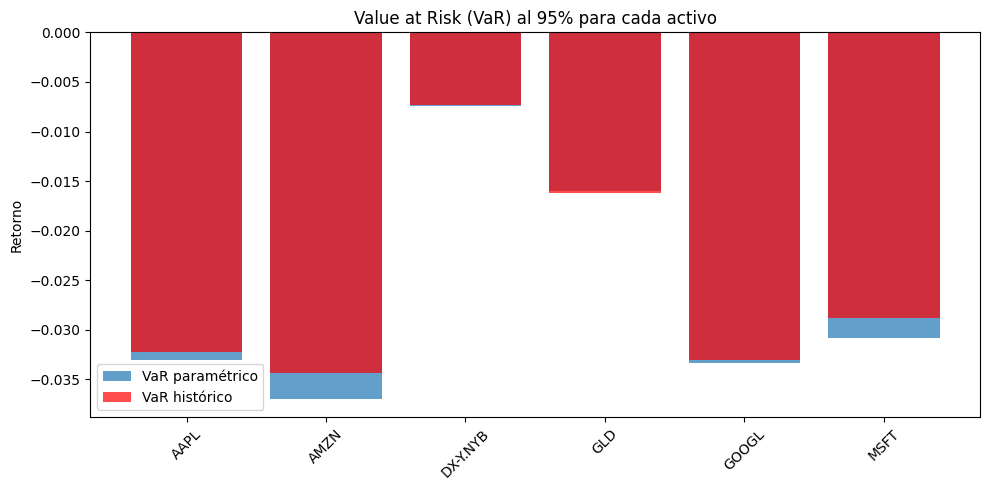

**Value at Risk (VaR):** El VaR al 95% indica la máxima pérdida esperada en un día, bajo condiciones normales de mercado, con un 95% de confianza. Es decir, hay un 5% de probabilidad de que la pérdida sea mayor a este valor.


In [12]:
plt.figure(figsize=(10,5))
plt.bar(VaR_param.index, VaR_param, alpha=0.7, label='VaR paramétrico')
plt.bar(VaR_hist.index, VaR_hist, alpha=0.7, label='VaR histórico', color='red')
plt.title('Value at Risk (VaR) al 95% para cada activo')
plt.ylabel('Retorno')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("**Value at Risk (VaR):** El VaR al 95% indica la máxima pérdida esperada en un día, bajo condiciones normales de mercado, con un 95% de confianza. Es decir, hay un 5% de probabilidad de que la pérdida sea mayor a este valor.")

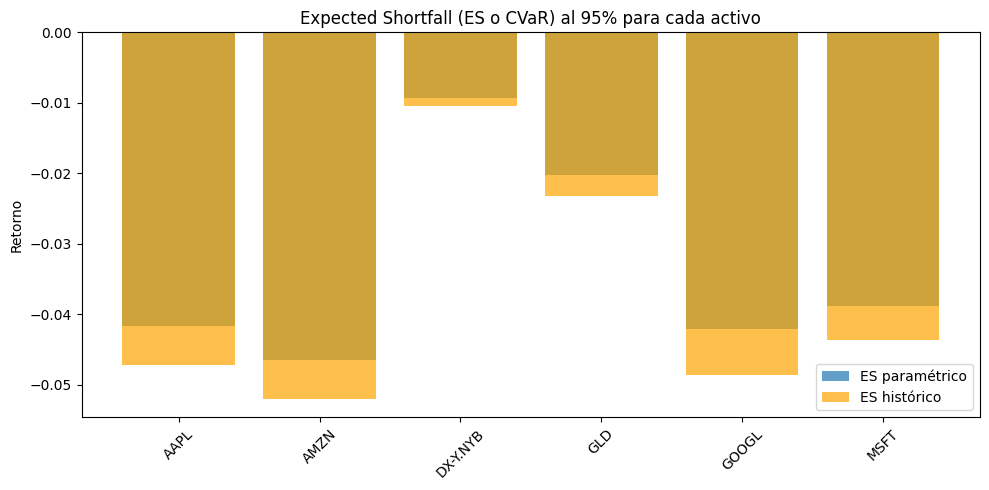

**Expected Shortfall (ES o CVaR):** El ES al 95% es el promedio de las peores pérdidas (el 5% de los peores días). Es una medida más conservadora que el VaR, ya que muestra cuánto podrías perder en promedio si superas el VaR.


In [13]:
plt.figure(figsize=(10,5))
plt.bar(ES_param.index, ES_param, alpha=0.7, label='ES paramétrico')
plt.bar(ES_hist.index, ES_hist, alpha=0.7, label='ES histórico', color='orange')
plt.title('Expected Shortfall (ES o CVaR) al 95% para cada activo')
plt.ylabel('Retorno')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("**Expected Shortfall (ES o CVaR):** El ES al 95% es el promedio de las peores pérdidas (el 5% de los peores días). Es una medida más conservadora que el VaR, ya que muestra cuánto podrías perder en promedio si superas el VaR.")